<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/master/06-model-evaluation/QualityMetrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quality metrics for classification

## Confusion matrix

Confusion matrix is a table with two rows and two columns that reports the number of true positives, false negatives, false positives, and true negatives. This allows more detailed analysis than simply observing the proportion of correct classifications (accuracy). Accuracy will yield misleading results if the data set is unbalanced; that is, when the numbers of observations in different classes vary greatly.

For example, if there were 95 cancer samples and only 5 non-cancer samples in the data, a particular classifier might classify all the observations as having cancer. The overall accuracy would be 95%, but in more detail the classifier would have a 100% recognition rate (sensitivity) for the cancer class but a 0% recognition rate for the non-cancer class. F1 score is even more unreliable in such cases, and here would yield over 97.4%, whereas informedness removes such bias and yields 0 as the probability of an informed decision for any form of guessing (here always guessing cancer).


**TP** = true positive

**FP** = false positive

**TN** = true negative

**FN** = false negative

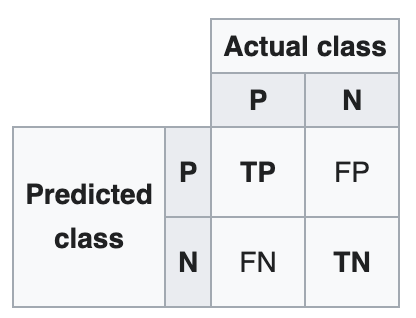

In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm, trange

cmap = mpl.colors.ListedColormap(['#992622', '#005AAA'])

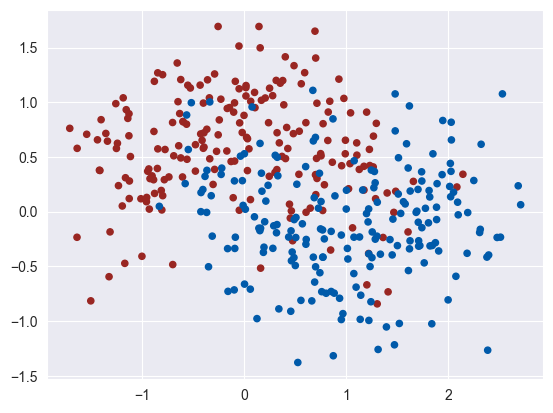

In [2]:
def gen_dataset(n_positive, n_negative):
  outer_circ_x = np.cos(np.linspace(0, np.pi, n_negative))
  outer_circ_y = np.sin(np.linspace(0, np.pi, n_negative))
  inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n_positive))
  inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, n_positive)) - .5

  X = np.vstack([np.append(outer_circ_x, inner_circ_x),
                 np.append(outer_circ_y, inner_circ_y)]).T
  y = np.hstack([np.zeros(n_negative, dtype=np.intp),
                 np.ones(n_positive, dtype=np.intp)])

  X += np.random.normal(scale=0.4, size=X.shape)

  return X, y

X, y = gen_dataset(200, 200)
plt.scatter(*X.T, c=y, s=20, cmap=cmap);

In [3]:
def plot_prediction(model, nx=100, ny=100, xmin=-2.5, xmax=3.5, ymin=-2.5, ymax=2.5):
  xx, yy = np.meshgrid(
      np.linspace(xmin, xmax, nx),
      np.linspace(ymin, ymax, ny)
  )

  preds = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,0].reshape(xx.shape)
  plt.contour(xx, yy, preds, levels=[0.5], colors='k', linewidths=3)

## Exercise 1: plotting TP, FP, TN and FN

Modify the code below to distinguish true positives, false positives, true negatives and false negatives on the plot. Add legend. **(2 points)**

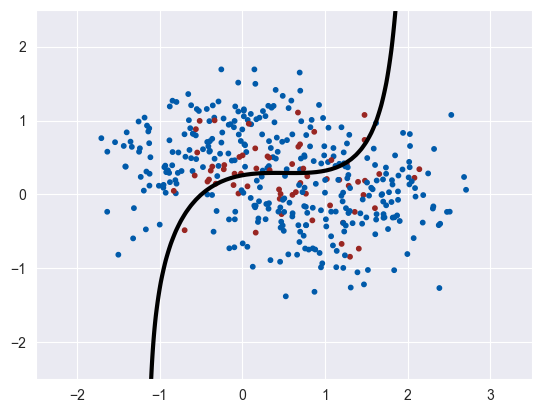

In [15]:
model = make_pipeline(
    RobustScaler(),
    PolynomialFeatures(3, include_bias=False),
    LogisticRegression()
)

model.fit(X, y)

preds = model.predict(X)

# Hint: use np.logical_and
TP = np.logical_and(y == 1, preds == 1)
TN = np.logical_and(y == 0, preds == 0)
FP = np.logical_and(y == 0, preds == 1)
FN = np.logical_and(y == 1, preds == 0)

# matplotlib.markers may help you https://matplotlib.org/stable/api/markers_api.html
plt.scatter(*X.T, c=[y==preds], s=10, cmap=cmap)
plot_prediction(model)

## Exercise 2: accuracy, precision, recall, F1 score

$$\text{accuracy}=\frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}$$

$$\text{precision}=\frac{\text{TP}}{\text{TP} + \text{FP}}$$

$$\text{recall}=\frac{\text{TP}}{\text{TP} + \text{FN}}$$

$$F_1=\frac{2\cdot\text{precision}\cdot\text{recall}}{\text{precision} + \text{recall}}$$

Implement the calculation of quality metrics in the function below. **(2 points)**

In [25]:
def calculate_metrics(y_true, y_pred):
    '''
    Function to calculate quality metrics.

    arguments:
    - y_true - numpy array of true labels (0 - negative class, 1 - positive class)
    - y_pred - numpy array of model predictions (0 - negative class, 1 - positive class)

    returns a tuple containing the calculated metrics:
    `(accuracy, precision, recall, f1)`
    '''
    TP = np.logical_and(y_true == 1, y_pred == 1).sum()
    TN = np.logical_and(y_true == 0, y_pred == 0).sum()
    FP = np.logical_and(y_true == 0, y_pred == 1).sum()
    FN = np.logical_and(y_true == 1, y_pred == 0).sum()
    # YOUR CODE: use only numpy operations to calculate the metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)

    return (accuracy, precision, recall, f1)


# Automatic checks:
import sklearn.metrics as skmetrics

dummy_y_true = np.array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0])
dummy_y_pred = np.array([1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0])

dummy_accuracy, dummy_precision, dummy_recall, dummy_f1 = \
  calculate_metrics(dummy_y_true, dummy_y_pred)
assert dummy_accuracy == skmetrics.accuracy_score(dummy_y_true, dummy_y_pred), 'Wrong accuracy'
assert dummy_precision == skmetrics.precision_score(dummy_y_true, dummy_y_pred), 'Wrong precision'
assert dummy_recall == skmetrics.recall_score(dummy_y_true, dummy_y_pred), 'Wrong recall'
assert dummy_f1 == skmetrics.f1_score(dummy_y_true, dummy_y_pred), 'Wrong F1 score'
print("All good!")

All good!


## Exercise 3: metrics as the function of class imbalance

Let's see how the metrics above behave when the classes are imbalanced.

For each $\alpha$ in `pos_class_fractions` below generate train and test datasets with $N = 50000$ points each, such that `n_positive`$ = \alpha N$, `n_negative`$ = (1 - \alpha)N$ (**don't foget to round and convert these numbers to integers!**). Train and evaluate the model on the generated data, plot test metrics (accuracy, precision, recall and F1) as a function of $\alpha$ on the same plot. **(3 points)**

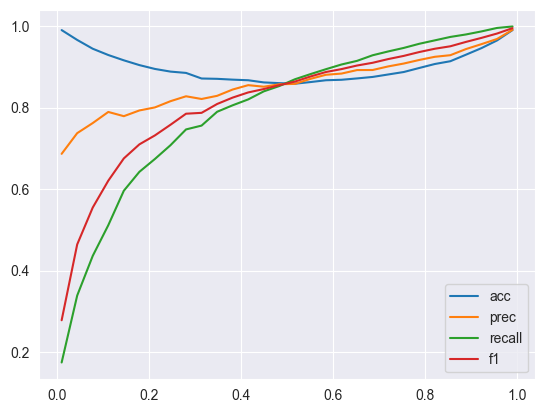

In [41]:
from sklearn.model_selection import train_test_split
pos_class_fractions = np.linspace(0.01, 0.99, 30)

model = make_pipeline(
    RobustScaler(),
    PolynomialFeatures(3, include_bias=False),
    LogisticRegression()
)

N = 50000

metrics_res = []

for a in pos_class_fractions:
    pos = int(N * a)
    neg = N - pos
    # use gen_dataset function
    X, y = gen_dataset(pos, neg)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5)
    model.fit(X_train, y_train)
    metrics_res.append(np.array(calculate_metrics(y_test, model.predict(X_test))))
metrics_res = np.array(metrics_res)

labels = ['acc', 'prec', 'recall', 'f1']
for i in range(4):
    plt.plot(pos_class_fractions, metrics_res[:,i], label=labels[i])
plt.legend()
plt.show()


## ROC curve

For a given model that gives the positive class score with $\hat{f}(x)$, prediction is obtained by thresholding this score with some threshold $T$:

$$\hat{y} = \mathbb{I}\left\{\hat{f}(x) \geq T\right\}$$

Then, true and false positive rates can be defined as functions of threshold.

True positive rate:
$$\text{TPR}(T) = \frac{\text{TP}(T)}{\text{TP}(T) + \text{FN}(T)}$$

False positive rate:
$$\text{FPR}(T) = \frac{\text{FP}(T)}{\text{FP}(T) + \text{TN}(T)}$$

ROC curve - TPR as a function of FPR.

Check out this nice demo: http://arogozhnikov.github.io/2015/10/05/roc-curve.html

Complete the code below and plot ROC curves **(1 point)**.

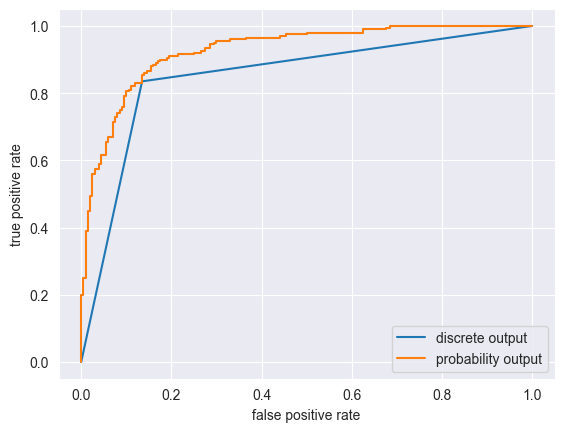

In [47]:
X_train, y_train = gen_dataset(200, 200)
X_test, y_test = gen_dataset(200, 200)

model = make_pipeline(
    RobustScaler(),
    PolynomialFeatures(3, include_bias=False),
    LogisticRegression()
)

model.fit(X_train, y_train)

#Make discreate predictions (class labels) and probability estimations.
preds_test = model.predict(X_test)
proba_test = model.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, preds_test)
plt.plot(fpr, tpr, label='discrete output');
fpr, tpr, _ = roc_curve(y_test, proba_test)
plt.plot(fpr, tpr, label='probability output');
# Add a plot related to a random model
# plt.plot(...)
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate');

Another metric - area under the ROC curve ("ROC AUC", or sometimes just "AUC").

 - AUC = 1.0 – perfect classification
 - AUC = 0.5 – random guess (worst classification)
 - AUC = 0.0 – perfect misclassification (converts to perfect classification by swapping the labels $1\leftrightarrow 0$)

In [48]:
from sklearn.metrics import roc_auc_score

print('AUC (discrete):', roc_auc_score(y_test, preds_test))
print('AUC (probability):', roc_auc_score(y_test, proba_test))

AUC (discrete): 0.85
AUC (probability): 0.927525


# Cross-validation

For more details: https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

To avoid overfitting, we typically leave a part of our data held out as the **test set**, to check the performance of a trained model on it:

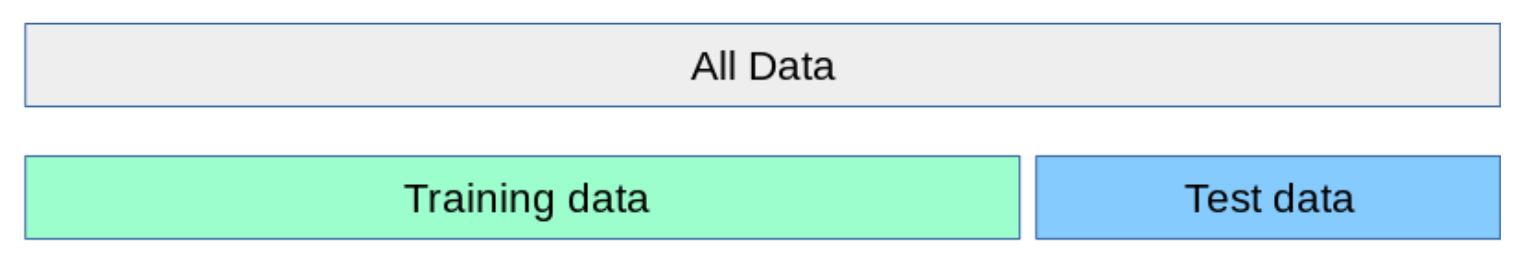

But if we use the test set to tune our parameters on it, we may "overfit to the test set". That is, the estimate of the model performance quality on that same test set would be biased.

An alternative approach would be to split the data into 3 parts:
 - **train** – to train the model on
 - **validation** – to evaluate the performance during hyperparameter tuning, and
 - **test** – to evalueate the performance of the final model

This, however, with this approach we drastically reduce the number of samples to be used to train the model.

An alternative approach is called Cross-validation (CV):

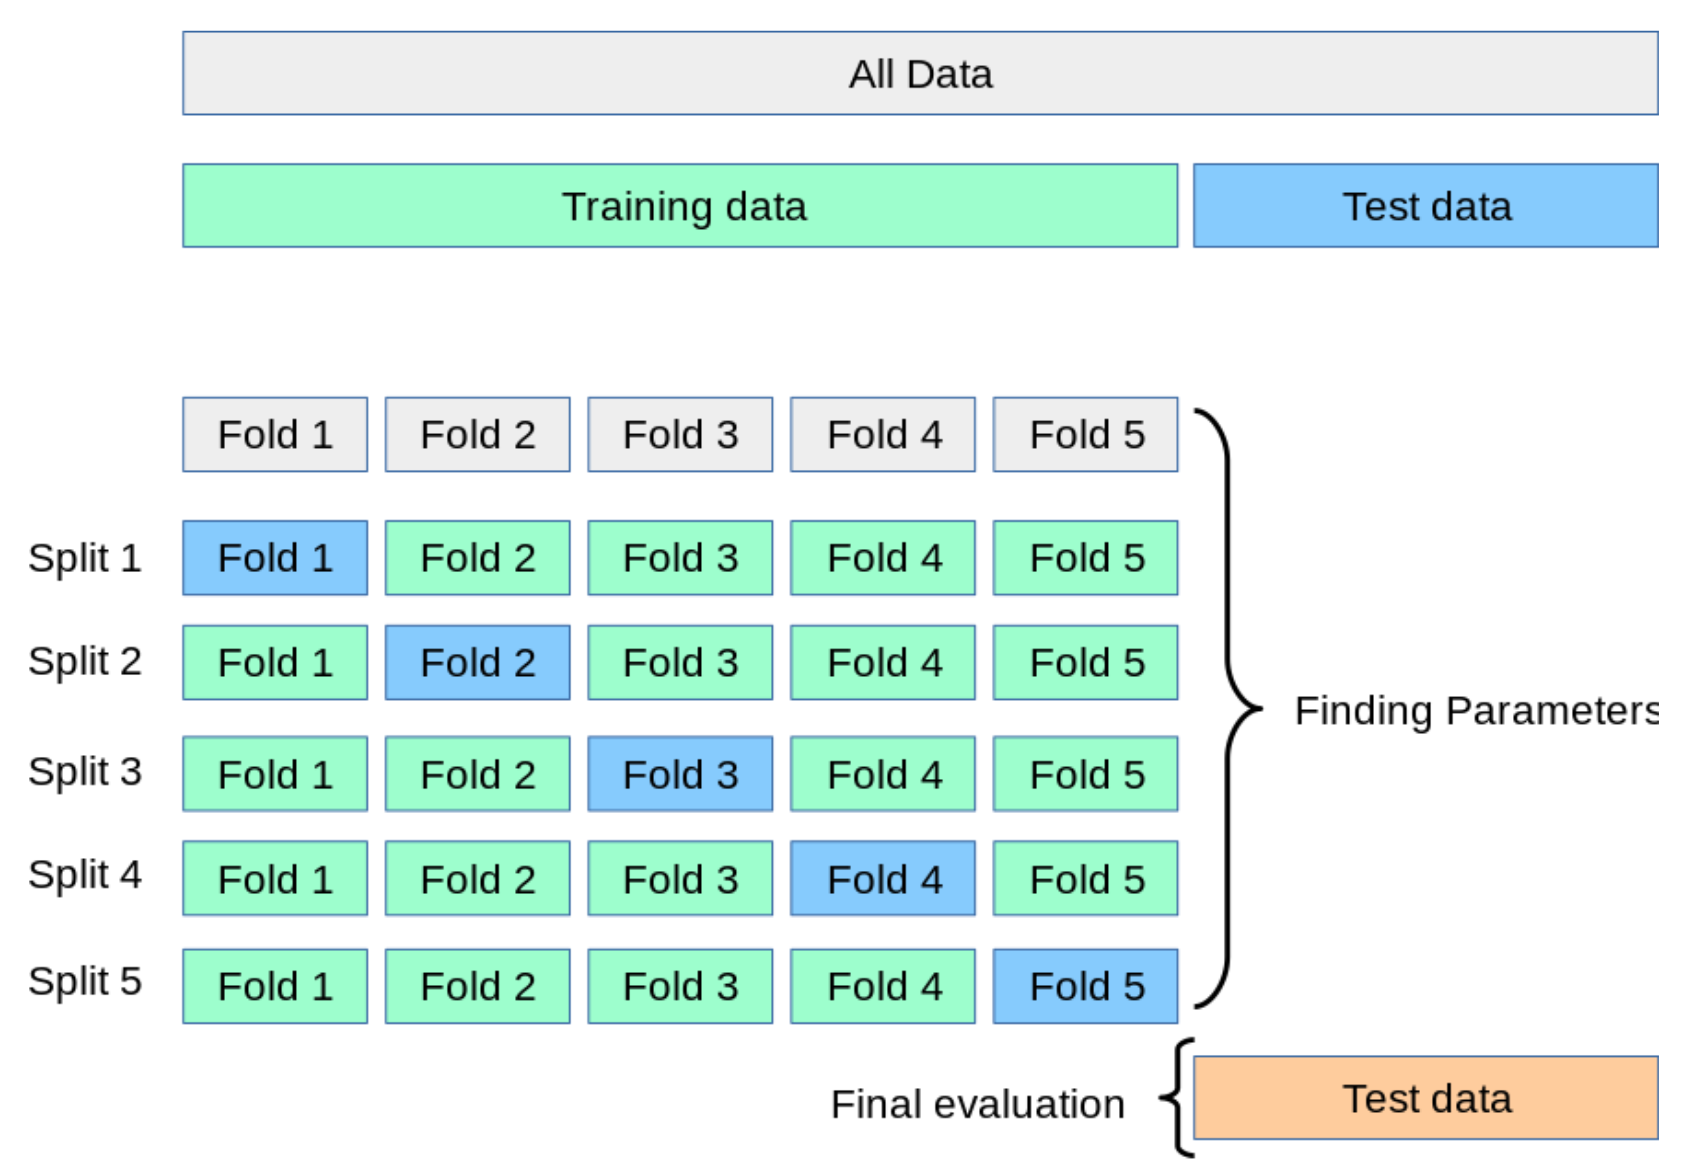

Example:

0.906840381840382
0.10835826927175334


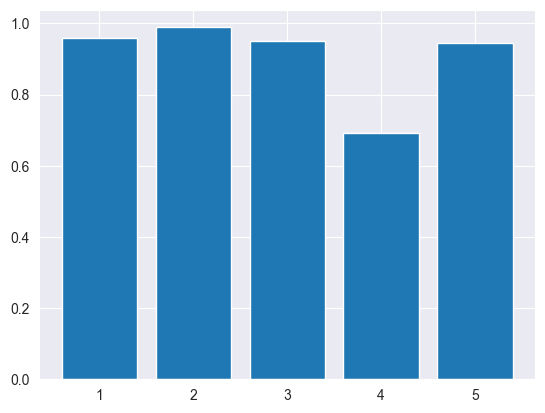

In [56]:
from sklearn.model_selection import KFold

X, y = gen_dataset(50, 50)

kf = KFold(n_splits=5, shuffle=True)
probs_roc = []
for i_train, i_test in kf.split(X):
  # print(i_train, i_test)

    X_train = X[i_train]
    y_train = y[i_train]
    X_test = X[i_test]
    y_test = y[i_test]

    model = make_pipeline(
        RobustScaler(),
        PolynomialFeatures(3, include_bias=False),
        LogisticRegression()
    )

    model.fit(X_train, y_train)

    #Make discreate predictions (class labels) and probability estimations.
    preds_test = model.predict(X_test)
    proba_test = model.predict_proba(X_test)[:, 1]
    # print('AUC (discrete):', roc_auc_score(y_test, preds_test))
    # print('AUC (probability):', roc_auc_score(y_test, proba_test))
    probs_roc.append(roc_auc_score(y_test, proba_test))
print(np.mean(probs_roc))
print(np.std(probs_roc))
plt.bar([1, 2, 3, 4, 5], probs_roc)
plt.show()

Complete the code above to evaluate the performance of the model (using ROC AUC). Increase the number of objects in the original dataset to 50 positives + 50 negatives. Calculate the mean and standard deviation of test ROC AUC estimates on the different folds, plot the histogram of test ROC AUC values on different folds. **(1 points)**

## Grid search CV

In [57]:
def plotting(param, score, score_error):
    plt.figure(figsize=(12, 5))
    plt.title("ROC_AUC score")
    plt.xlabel('param_value')
    plt.ylabel('ROC_AUC score')
    plt.plot(param, score,'o-', color='b', ms=5, label="ROC_AUC score")
    plt.fill_between(param,
                     score - 1.96 * score_error,
                     score + 1.96 * score_error,
                     facecolor='g', alpha=0.6, label="95% confidence interval")
    plt.legend()
    plt.grid()

In [58]:
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

X, y = gen_dataset(50, 50)

base_model = make_pipeline(
  RobustScaler(),
  SVC(kernel='rbf')
)

param_grid = {'svc__gamma': np.logspace(-2, 2, 41, base=10)}

gscv = GridSearchCV(base_model, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)

gscv.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('robustscaler', RobustScaler()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__gamma': array([1.00000000e-02, 1.25892541e-02, 1.58489319e-02, 1.99526231e-02,
       2.51188643e-02, 3.16227766e-02, 3.98107171e-02, 5.01187234e-02,
       6.30957344e-02, 7.94328235e-02, 1.00000000e-01, 1.25892541e-01,
       1.58489319e-01, 1.99526231e-01, 2.5118...
       3.98107171e-01, 5.01187234e-01, 6.30957344e-01, 7.94328235e-01,
       1.00000000e+00, 1.25892541e+00, 1.58489319e+00, 1.99526231e+00,
       2.51188643e+00, 3.16227766e+00, 3.98107171e+00, 5.01187234e+00,
       6.30957344e+00, 7.94328235e+00, 1.00000000e+01, 1.25892541e+01,
       1.58489319e+01, 1.99526231e+01, 2.51188643e+01, 3.16227766e+01,
       3.98107171e+01, 5.01187234e+01, 6.30957344e+01, 7.94328235e+01,
       1.00000000e+02])},
             scoring='roc_auc')

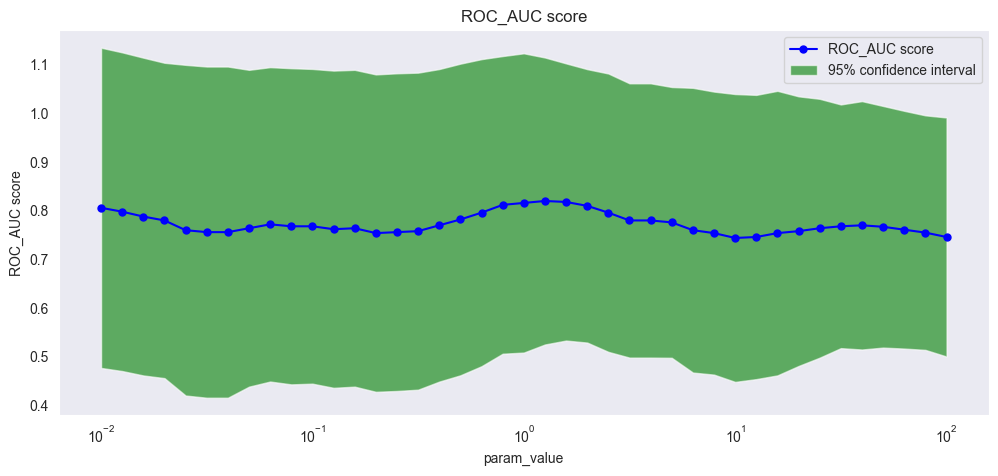

In [59]:
plotting(gscv.param_grid['svc__gamma'],
         gscv.cv_results_['mean_test_score'],
         gscv.cv_results_['std_test_score'] / (gscv.cv - 1)**0.5)
plt.xscale('log');

# Bonus part. Text classification 🎃

Now let's try to apply all approaches that were discussed above using [Spooky Author Identification](https://www.kaggle.com/c/spooky-author-identification) data. You may earn **4 points** if you send the solution by the end of the this practicall session's day. Feel free to add any kind of plotting, lines of code etc., but try to make your solution well annotated. 

In case you run colab version of the notebook, you may just execute the cell below to download the data. 

In [6]:
!wget https://drive.google.com/uc?id=1urSb8jLg1ucXyJUrMWUX6HNrIHYbDSlq

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn import preprocessing, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BRINE\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


"In this year's Halloween playground competition, you're challenged to predict the author of excerpts from horror stories by Edgar Allan Poe, Mary Shelley, and HP Lovecraft." Kaggle (C)

In [22]:
train = pd.read_csv('train.csv')

It is possible to perform text classification with 3 different classes, but you may try to drop one of the authors in order to solve binary classification problem. Otherwise, choose appropriate quality metrics. For this particular problem, Kaggle itself has specified [multi-class log-loss as evaluation metric](https://www.kaggle.com/c/spooky-author-identification/overview/evaluation).

In [5]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [7]:
train.author.value_counts()

author
EAP    7900
MWS    6044
HPL    5635
Name: count, dtype: int64

Drop one author from the dataset and choose a metric that will be used through the code below. Think of class balance in case it takes place in your case.

In [23]:
train = train[train['author'] != 'MWS']

In [24]:
main_metric = metrics.accuracy_score

Firstly, lets convert labels into integers.

*Hint:* you may use `sklearn.preprocessing.LabelEncoder()`

In [25]:
from sklearn.preprocessing import LabelEncoder
label_transformer = LabelEncoder()
y = label_transformer.fit_transform(train['author'])

In [26]:
y

array([0, 1, 0, ..., 0, 0, 1])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(train.text.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In order to work with a collection of text documents we need to extract numerical features.

A bag-of-words model (BoW) is a representation of text that describes the occurrence of words within a document, being called a “bag”, because any information about the order or structure of words in the document is discarded after such transformation. It involves a vocabulary of known words and the measure of the presence of known words.


`sklearn.feature_extraction.text.CountVectorizer` converts a collection of text documents to a matrix of token counts.

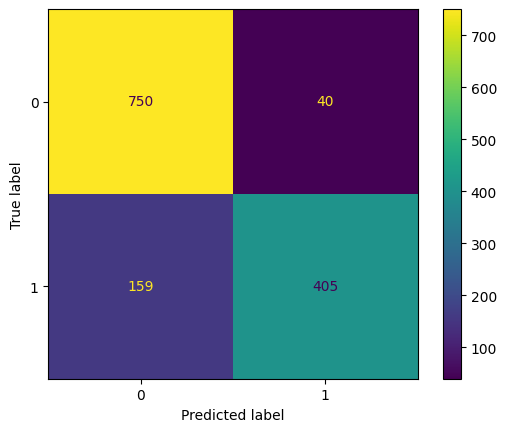

In [31]:
# A built-in stop word list for English is used, but you may pass your own one
ctv = CountVectorizer(analyzer='word', ngram_range=(1, 3), stop_words = 'english')

# Can we use X_test fitting the vectorizer?
ctv.fit(train.text.values)

X_train_ctv =  ctv.transform(X_train) 
X_test_ctv = ctv.transform(X_test)

clf = LogisticRegression()
clf.fit(X_train_ctv, y_train)

#Depends on type of main_metric
predictions = clf.predict(X_test_ctv)

#This part is sensitive to sklearn version
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [32]:
main_metric(y_test, predictions)

0.8530280649926145

Now let's try [TF-IDF (Term Frequency - Inverse Document Frequency)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer).

`TfidfVectorizer` is equivalent to `CountVectorizer` followed by `TfidfTransformer`, so you may use an existing vectorizer and perform the transition or define a new instance of transformer.

$$\text{tfidf}(t, d) = \text{tf}(t, d) * \text{idf}(t),$$ $$\text{idf}(t) = \log\frac{n}{\text{df}(t)} + 1,$$ if smooth_idf=False, where $n$ is the total number of documents in the document set and df($t$) is the document frequency of $t$.

The document frequency is the number of documents in the document set that contain the term $t$. The effect of adding “1” to the idf in the equation above is that terms with zero idf, i.e., terms that occur in all documents in a training set, will not be entirely ignored. 
The formula above differs from the standard textbook notation that defines the idf as $\text{idf}(t) = log \frac{n}{df(t) + 1}$, but it is used in `sklearn`.

If smooth_idf=True (the default), the constant “1” is added to the numerator and denominator of the idf as if an extra document was seen containing every term in the collection exactly once, which prevents zero divisions: $$ \text{idf}(t) = log \frac{1 + n}{1 + df(t)}+ 1$$

In [33]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, analyzer='word',
            ngram_range=(1, 3), use_idf=1, sublinear_tf=1, stop_words = 'english')

# Can we use X_test fitting the vectorizer?
tfv.fit(train.text.values)
X_train_tfv =  tfv.transform(X_train) 
X_test_tfv = tfv.transform(X_test)

clf = LogisticRegression()
clf.fit(X_train_tfv, y_train)

#Depends on type of main_metric
predictions = clf.predict(X_test_tfv)

main_metric(y_test, predictions)

C:\PYTHON\Python\lib\site-packages\sklearn\utils\_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


0.8559822747415067

You may try to reduce the number of features setting corresponding parameters (max_df, min_df, etc), but it is also possible to apply dimensionality reduction approaches like truncated SVD (aka LSA) and use `SVC`.

In [35]:
svd = TruncatedSVD(n_components=1000)
svd.fit(X_train_tfv)

X_train_svd = svd.transform(X_train_tfv)
X_test_svd = svd.transform(X_test_tfv)

# It is better to scale data before using SVC
scl = preprocessing.StandardScaler()
scl.fit(X_train_svd)

X_train_svd_scl = scl.transform(X_train_svd)
X_test_svd_scl = scl.transform(X_test_svd)

# Set probability=True in case you need probabilities for your QM
clf = SVC(C=1.0, probability=False) 
clf.fit(X_train_svd_scl, y_train)

predictions = clf.predict(X_test_svd_scl)

main_metric(y_test, predictions)

0.8530280649926145

In [ ]:
#Try to tune the parameters using GridSearch
gs_scorer = metrics.make_scorer(main_metric, greater_is_better=..., needs_proba=...)

model = GridSearchCV(estimator=..., param_grid=..., scoring=gs_scorer, ...)